# Лабораторная работа №1

_Выполнили: Гуревич Михаил и Трохан Александр, M33001_

In [666]:
from typing import Literal

import json

import numpy as np
from prettytable import PrettyTable
from matplotlib import pyplot as plt

from fractions import Fraction

## Реализация алгоритма
Код разделён на классы, и для симплекс-метода реализован отдельный класс.

Вспомогательные функции:

In [667]:
TYPES = {
    "leq": "≤",
    "geq": "≥",
    "eq": "="
}


def append_to_problem(string: str, coef: Fraction, i: int):
    if coef != 0:
        if len(string) > 0:
            if coef == 1:
                string += f" + x_{i + 1}"
            elif coef == -1:
                string += f" - x_{i + 1}"
            elif coef > 0:
                string += f" + {coef}x_{i + 1}"
            else:
                string += f" - {-coef}x_{i + 1}"
        
        else:
            if coef == 1:
                string += f"x_{i + 1}"
            elif coef == -1:
                string += f"-x_{i + 1}"
            else:
                string += f"{coef}x_{i + 1}"
        
    return string
        
def type_to_string(type: str):
    return TYPES[type]

Классы ограничения и Задачи линейного программирования:

In [668]:
class Constraint:
    """Constraint class for linear programming problem"""

    def __init__(self, coefs: list[Fraction], type: Literal["eq", "leq", "geq"], b: Fraction):
        if type not in {"leq", "geq", "eq"}:
            raise ValueError("Type must be one of \"leq\", \"geq\", \"eq\"")
        if len(coefs) == 0:
            raise ValueError("Coefs must not be empty")

        self.coefs = list(map(lambda x: Fraction(x), coefs))
        self.type = type
        self.b = b     

    def __call__(self, x: list[Fraction]):
        lhs = np.dot(self.coefs, x)
        if self.type == "leq":
            return lhs <= self.b
        elif self.type == "geq":
            return lhs >= self.b
        else:
            return lhs == self.b
        
    def __str__(self):
        string = ""
        for i, coef in enumerate(self.coefs):
            string = append_to_problem(string, coef, i)
        string += f" {type_to_string(self.type)} {self.b}"
        return string


class LinearProgram:
    """Linear programming problem class"""

    @staticmethod
    def validate(f: list[Fraction], goal: Literal["min", "max"], constraints: list[Constraint]):
        if len(f) == 0 or not any(f):
            raise ValueError("Function must not be empty")
        if goal not in {"min", "max"}:
            raise ValueError("Goal must be one of \"min\", \"max\"")
        if len(constraints) == 0:
            raise ValueError("Constraints must not be empty")
        for constraint in constraints:
            if len(constraint.coefs) != len(constraints[0].coefs) or len(constraint.coefs) != len(f) or not any(constraint.coefs):
                raise ValueError("All constraints must have the same number of coefficients equal to the number of variables in the function")
            
    @staticmethod
    def from_json(path: str):
        with open(path) as f:
            data = json.load(f)
            constraints = list(map(lambda c: Constraint(**c), data["constraints"]))
            return LinearProgram(data["f"], data["goal"], constraints)

    def __init__(self, f: list[Fraction], goal: Literal["min", "max"], constraints: list[Constraint]):
        LinearProgram.validate(f, goal, constraints)

        self.f = list(map(lambda x: Fraction(x), f))
        self.goal = goal
        self.constraints = constraints

    def __str__(self):
        result = "Problem:\n"
        
        problem = ""
        for i, coef in enumerate(self.f):
            problem = append_to_problem(problem, coef, i)
        problem += f" -> {self.goal}\n"

        result += f"{problem}\nConstraints:\n"

        for constraint in self.constraints:
            string = ""
            for i, coef in enumerate(constraint.coefs):
                string = append_to_problem(string, coef, i)
            string += f" {type_to_string(constraint.type)} {constraint.b}"
            result += f"{string}\n"

        return result

Класс симплекс-таблицы:

In [669]:
class SimplexTable:
    """Simplex table class"""

    def __init__(self):
        self.table: list[np.ndarray] = []
        self.basic_variables: list[int] = []

    def append_row(self, basis: int, row: list[Fraction]):
        """Appends row to the table"""
        self.basic_variables.append(basis)
        self.table.append(np.array(row))

    def sum_rows(self, row1: int, row2: int, coef: Fraction=1):
        """Sums row2 to row1 with given coefficient"""
        self.table[row1] = np.add(self.table[row1], np.multiply(self.table[row2], coef))

    def subtract_rows(self, row1: int, row2: int):
        """Subtracts row2 from row1"""
        self.sum_rows(row1, row2, -1)

    def __getitem__(self, key: int) -> np.ndarray:
        """Returns row with given index"""
        return self.table[key]
    
    def __setitem__(self, key: int, value: list[Fraction] | np.ndarray):
        """Sets row with given index"""
        self.table[key] = value if isinstance(value, np.ndarray) else np.array(value)

    def print(self):
        table = PrettyTable()
        table.field_names = ["Basis"] + [f"x_{i + 1}" for i in range(len(self.table[0]) - 1)] + ["b"]
        for i, row in enumerate(self.table):
            if (self.basic_variables[i] == -1):
                table.add_row(["f"] + row.tolist())
            else:
                table.add_row([f"x_{self.basic_variables[i] + 1}"] + row.tolist())
        
        print(table)

In [670]:
class SimplexSolver:
    """2-phase simplex method solver"""

    def __init__(self, problem: LinearProgram):
        self.problem = problem

    def solve(self, disp: bool=False):
        self.disp = disp

        self.original_goal = self.problem.goal
        if self.problem.goal == "min":
            self.problem.f = np.multiply(self.problem.f, -1)
            self.problem.goal = "max"

        self._phase1()

        return self._get_solution()

    def _phase1(self):
        # eliminate negative b
        for constraint in self.problem.constraints:
            if constraint.b < 0:
                constraint.coefs = np.multiply(constraint.coefs, -1).tolist()
                constraint.b *= -1
                if constraint.type == "leq":
                    constraint.type = "geq"
                elif constraint.type == "geq":
                    constraint.type = "leq"

        geqs = len(list(filter(lambda c: c.type == "geq", self.problem.constraints)))
        leqs = len(list(filter(lambda c: c.type == "leq", self.problem.constraints)))
        eqs = len(list(filter(lambda c: c.type == "eq", self.problem.constraints)))

        self.simplex_table = SimplexTable()
        cur_geqs, cur_leqs, cur_eqs, initial_count = 0, 0, 0, len(self.problem.f)
        rows_to_subtract = []
        # variables in a row always go in the following order:
        # x_1, x_2, ..., x_n, slack variables, excess variables, artificial variables, b
        for i, constraint in enumerate(self.problem.constraints):
            row = constraint.coefs
            if constraint.type == "leq":
                row += [0] * cur_leqs + [1] + [0] * (leqs - cur_leqs - 1) + [0] * geqs + [0] * (geqs + eqs) + [constraint.b]
                self.simplex_table.append_row(initial_count + cur_leqs, row)
                cur_leqs += 1
            elif constraint.type == "geq":
                row += [0] * leqs + [0] * cur_geqs + [-1] + [0] * (geqs - cur_geqs - 1) + [0] * (cur_geqs + cur_eqs) + [1] + [0] * (geqs + eqs - cur_geqs - cur_eqs - 1) + [constraint.b]
                self.simplex_table.append_row(initial_count + leqs + geqs + cur_geqs + cur_eqs, row)
                rows_to_subtract.append(i)
                cur_geqs += 1
            else:
                row += [0] * leqs + [0] * geqs + [0] * (cur_geqs + cur_eqs) + [1] + [0] * (geqs + eqs - cur_geqs - cur_eqs - 1) + [constraint.b]
                self.simplex_table.append_row(initial_count + leqs + geqs + cur_geqs + cur_eqs, row)
                rows_to_subtract.append(i)
                cur_eqs += 1
        # add last row for auxiliary problem, which maximizes sum of artificial variables: f = -a_1 - a_2 - ... - a_m
        self.simplex_table.append_row(-1, [0] * (initial_count + leqs + geqs) + [1] * (geqs + eqs) + [0])

        for row in rows_to_subtract:
            self.simplex_table.subtract_rows(-1, row)

        if self.disp:
            print("(Phase 1) Initial table for auxiliary problem:")
            self.simplex_table.print()

        # solve auxiliary problem
        self._pivot()

        if self.disp:
            print("(Phase 1) Auxiliary problem solved, checking if solution is feasible")
        
        # check if solution is feasible
        if self.simplex_table[-1][-1] != 0:
            if self.disp:
                print(f"Solution is not feasible, {self.simplex_table[-1][-1]} != 0")
            raise ValueError("No feasible solution found")
        elif self.disp:
            print("Solution is feasible")
        
        self._phase2()

    def _phase2(self):
        # change objective function from auxiliary problem to original problem
        self.simplex_table[-1] = np.concatenate([np.multiply(self.problem.f, -1), np.zeros(len(self.simplex_table[-1]) - len(self.problem.f), dtype=Fraction)])

        for i, basic in enumerate(self.simplex_table.basic_variables[:-1]):
            if self.simplex_table[-1][basic] != 0:
                self.simplex_table.sum_rows(-1, i, -self.simplex_table[-1][basic])

        if self.disp:
            print("(Phase 2) Initial table for original problem:")
            self.simplex_table.print()

        # solve original problem
        self._pivot()

    def _get_solution(self):
        solution = [0] * len(self.problem.f)
        for i, row in enumerate(self.simplex_table):
            if self.simplex_table.basic_variables[i] < len(solution) and self.simplex_table.basic_variables[i] != -1:
                solution[self.simplex_table.basic_variables[i]] = row[-1]
        
        if self.disp:
            print("Solution:")
            for i in range(len(self.problem.f)):
                print(f"x_{i + 1} = {solution[i]}", end=", ")
            function_value = self.simplex_table[-1][-1] * (1 if self.original_goal == "max" else -1)
            print(f"function value: {function_value}")
        return solution, function_value

    def _pivot(self):
        # find column to pivot
        f = self.simplex_table[-1]
        if all(c >= 0 for c in f[:-1]):
            # no negative elements in last row, problem is solved
            return
        pivot_col = f[:-1].argmin()

        # find row to pivot
        pivot_row = None
        min_ratio = None
        for i, row in enumerate(self.simplex_table[:-1]):
            if row[pivot_col] > 0:
                ratio = Fraction(row[-1], row[pivot_col])
                if min_ratio is None or ratio < min_ratio:
                    min_ratio = ratio
                    pivot_row = i

        # if no row to pivot found, problem is unbounded
        if pivot_row is None:
            raise ValueError("Problem is unbounded")

        # pivot
        self.simplex_table[pivot_row] = np.divide(self.simplex_table[pivot_row], self.simplex_table[pivot_row][pivot_col]).tolist()
        for i, row in enumerate(self.simplex_table):
            if i != pivot_row:
                self.simplex_table.sum_rows(i, pivot_row, -row[pivot_col])

        if self.disp:
            print(f"Pivot row: {pivot_row + 1}, pivot column: {pivot_col + 1} (swapping x_{self.simplex_table.basic_variables[pivot_row] + 1} and x_{pivot_col + 1}):")

        # update basic variables
        self.simplex_table.basic_variables[pivot_row] = pivot_col

        if self.disp:
            self.simplex_table.print()

        self._pivot()

## Тестирование алгоритма

### Визуализация работы:

Вывод таблиц:

In [671]:
problem = LinearProgram.from_json("example.json")
print(problem)
solver = SimplexSolver(problem)
try:
    solver.solve(disp=True)
except ValueError as e:
    print(e)

Problem:
6x_1 + x_2 -> max

Constraints:
-x_1 + 3x_2 ≤ 6
x_1 - 3x_2 ≤ 6
x_1 + x_2 ≥ 1

(Phase 1) Initial table for auxiliary problem:
+-------+-----+-----+-----+-----+-----+-----+----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6 | b  |
+-------+-----+-----+-----+-----+-----+-----+----+
|  x_3  |  -1 |  3  |  1  |  0  |  0  |  0  | 6  |
|  x_4  |  1  |  -3 |  0  |  1  |  0  |  0  | 6  |
|  x_6  |  1  |  1  |  0  |  0  |  -1 |  1  | 1  |
|   f   |  -1 |  -1 |  0  |  0  |  1  |  0  | -1 |
+-------+-----+-----+-----+-----+-----+-----+----+
Pivot row: 3, pivot column: 1 (swapping x_6 and x_1):
+-------+-----+-----+-----+-----+-----+-----+---+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6 | b |
+-------+-----+-----+-----+-----+-----+-----+---+
|  x_3  |  0  |  4  |  1  |  0  |  -1 |  1  | 7 |
|  x_4  |  0  |  -4 |  0  |  1  |  1  |  -1 | 5 |
|  x_1  |  1  |  1  |  0  |  0  |  -1 |  1  | 1 |
|   f   |  0  |  0  |  0  |  0  |  0  |  1  | 0 |
+-------+-----+-----+-----+-----+-----+-----+---+
(Pha

График области допустимых решений:

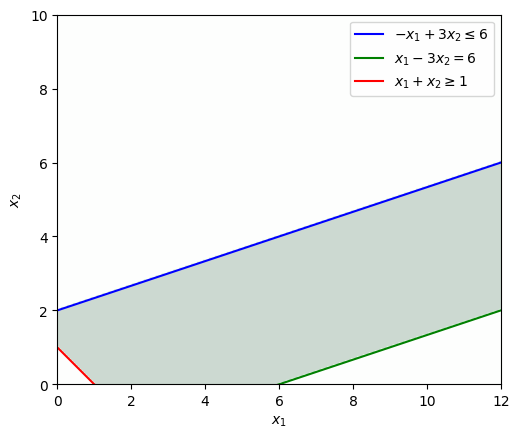

In [672]:
d = np.linspace(0, 16, 300)
x_1, x_2 = np.meshgrid(d, d)
plt.imshow(((-x_1 + 3 * x_2 <= 6) & (x_1 - 3 * x_2 <= 6) & (x_1 + x_2 >= 1)).astype(int),
           extent=(x_1.min(), x_2.max(), x_1.min(), x_2.max()), origin="lower", cmap="Greens", alpha=0.2)

x = np.linspace(0, 16, 2000)
line1 = (6 + x) / 3  # -x_1 + 3x_2 <= 6
line2 = (x - 6) / 3  # x_1 - 3x_2 <= 6
line3 = 1 - x  # x_1 + x_2 >= 1

plt.plot(x, line1, label=r"$-x_1 + 3x_2 \leq 6$", c="b")
plt.plot(x, line2, label=r"$x_1 - 3x_2 = 6$", c="g")
plt.plot(x, line3, label=r"$x_1 + x_2 \geq 1$", c="r")
plt.xlim(0, 12)
plt.ylim(0, 10)
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

### Другие примеры без визуализации:

In [673]:
correct = ([Fraction(28, 5), 0, 0, Fraction(1, 5), Fraction(12, 5)], Fraction(-11, 5))

problem = LinearProgram.from_json("test1.json")
print(problem)
solver = SimplexSolver(problem)
try:
    solution, function_value = solver.solve(disp=True)
    for i, elem in enumerate(solution):
        assert correct[0][i] == elem, f"{correct[0][i]} != {elem}"
    assert correct[1] == function_value
    print("Test 1 passed")
except ValueError as e:
    print(e)

Problem:
x_4 - x_5 -> min

Constraints:
x_1 + x_4 - 2x_5 = 1
-2x_4 + x_5 = 2
x_3 + 3x_4 + x_5 = 3

(Phase 1) Initial table for auxiliary problem:
+-------+-----+-----+-----+-----+-----+-----+-----+-----+----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6 | x_7 | x_8 | b  |
+-------+-----+-----+-----+-----+-----+-----+-----+-----+----+
|  x_6  |  1  |  0  |  0  |  1  |  -2 |  1  |  0  |  0  | 1  |
|  x_7  |  0  |  0  |  0  |  -2 |  1  |  0  |  1  |  0  | 2  |
|  x_8  |  0  |  0  |  1  |  3  |  1  |  0  |  0  |  1  | 3  |
|   f   |  -1 |  0  |  -1 |  -2 |  0  |  0  |  0  |  0  | -6 |
+-------+-----+-----+-----+-----+-----+-----+-----+-----+----+
Pivot row: 1, pivot column: 4 (swapping x_6 and x_4):
+-------+-----+-----+-----+-----+-----+-----+-----+-----+----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6 | x_7 | x_8 | b  |
+-------+-----+-----+-----+-----+-----+-----+-----+-----+----+
|  x_4  |  1  |  0  |  0  |  1  |  -2 |  1  |  0  |  0  | 1  |
|  x_7  |  2  |  0  |  0  |  0  |  -3 |  2  

In [674]:
correct = ([Fraction(18, 5), Fraction(32, 5)], 34000)

problem = LinearProgram.from_json("test2.json")
print(problem)
solver = SimplexSolver(problem)
try:
    solution, function_value = solver.solve(disp=True)
    for i, elem in enumerate(solution):
        assert correct[0][i] == elem, f"{correct[0][i]} != {elem}"
    assert correct[1] == function_value
    print("Test 2 passed")
except ValueError as e:
    print(e)

Problem:
5000x_1 + 2500x_2 -> max

Constraints:
4x_1 + 3/2x_2 ≤ 24
1200x_1 + 150x_2 ≤ 6000
20x_1 + 20x_2 ≤ 200
x_1 ≥ 2

(Phase 1) Initial table for auxiliary problem:
+-------+------+-----+-----+-----+-----+-----+-----+------+
| Basis | x_1  | x_2 | x_3 | x_4 | x_5 | x_6 | x_7 |  b   |
+-------+------+-----+-----+-----+-----+-----+-----+------+
|  x_3  |  4   | 3/2 |  1  |  0  |  0  |  0  |  0  |  24  |
|  x_4  | 1200 | 150 |  0  |  1  |  0  |  0  |  0  | 6000 |
|  x_5  |  20  |  20 |  0  |  0  |  1  |  0  |  0  | 200  |
|  x_7  |  1   |  0  |  0  |  0  |  0  |  -1 |  1  |  2   |
|   f   |  -1  |  0  |  0  |  0  |  0  |  1  |  0  |  -2  |
+-------+------+-----+-----+-----+-----+-----+-----+------+
Pivot row: 4, pivot column: 1 (swapping x_7 and x_1):
+-------+-----+-----+-----+-----+-----+------+-------+------+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6  |  x_7  |  b   |
+-------+-----+-----+-----+-----+-----+------+-------+------+
|  x_3  |  0  | 3/2 |  1  |  0  |  0  |  4   |   -4  

In [675]:
correct = ([3, 0], 12)

problem = LinearProgram.from_json("test3.json")
print(problem)
solver = SimplexSolver(problem)
try:
    solution, function_value = solver.solve(disp=True)
    for i, elem in enumerate(solution):
        assert correct[0][i] == elem, f"{correct[0][i]} != {elem}"
    assert correct[1] == function_value
    print("Test 3 passed")
except ValueError as e:
    print(e)

Problem:
4x_1 + 5x_2 -> max

Constraints:
2x_1 + 3x_2 ≤ 6
3x_1 + x_2 ≥ 3

(Phase 1) Initial table for auxiliary problem:
+-------+-----+-----+-----+-----+-----+----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | b  |
+-------+-----+-----+-----+-----+-----+----+
|  x_3  |  2  |  3  |  1  |  0  |  0  | 6  |
|  x_5  |  3  |  1  |  0  |  -1 |  1  | 3  |
|   f   |  -3 |  -1 |  0  |  1  |  0  | -3 |
+-------+-----+-----+-----+-----+-----+----+
Pivot row: 2, pivot column: 1 (swapping x_5 and x_1):
+-------+-----+-----+-----+------+------+---+
| Basis | x_1 | x_2 | x_3 | x_4  | x_5  | b |
+-------+-----+-----+-----+------+------+---+
|  x_3  |  0  | 7/3 |  1  | 2/3  | -2/3 | 4 |
|  x_1  |  1  | 1/3 |  0  | -1/3 | 1/3  | 1 |
|   f   |  0  |  0  |  0  |  0   |  1   | 0 |
+-------+-----+-----+-----+------+------+---+
(Phase 1) Auxiliary problem solved, checking if solution is feasible
Solution is feasible
(Phase 2) Initial table for original problem:
+-------+-----+-------+-----+------+------+---+
| Ba

In [676]:
# this example is unbounded
problem = LinearProgram.from_json("test4.json")
print(problem)
solver = SimplexSolver(problem)
try:
    solver.solve(disp=True)
except ValueError as e:
    print(e)
    print("Test 4 passed")

Problem:
2x_1 + 3x_2 -> min

Constraints:
1/2x_1 + 1/4x_2 ≤ 4
x_1 + 3x_2 ≥ 36
x_1 + x_2 = 10

(Phase 1) Initial table for auxiliary problem:
+-------+-----+-----+-----+-----+-----+-----+-----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6 |  b  |
+-------+-----+-----+-----+-----+-----+-----+-----+
|  x_3  | 1/2 | 1/4 |  1  |  0  |  0  |  0  |  4  |
|  x_5  |  1  |  3  |  0  |  -1 |  1  |  0  |  36 |
|  x_6  |  1  |  1  |  0  |  0  |  0  |  1  |  10 |
|   f   |  -2 |  -4 |  0  |  1  |  0  |  0  | -46 |
+-------+-----+-----+-----+-----+-----+-----+-----+
Pivot row: 3, pivot column: 2 (swapping x_6 and x_2):
+-------+-----+-----+-----+-----+-----+------+-----+
| Basis | x_1 | x_2 | x_3 | x_4 | x_5 | x_6  |  b  |
+-------+-----+-----+-----+-----+-----+------+-----+
|  x_3  | 1/4 |  0  |  1  |  0  |  0  | -1/4 | 3/2 |
|  x_5  |  -2 |  0  |  0  |  -1 |  1  |  -3  |  6  |
|  x_2  |  1  |  1  |  0  |  0  |  0  |  1   |  10 |
|   f   |  2  |  0  |  0  |  1  |  0  |  4   |  -6 |
+-------+-----+---